 <h1>1.  Chest X-Ray Medical Diagnosis with Deep Learning
 </h1>

<h1>1. Business Problem </h1>

<h2> 1.1 Description </h2>

## National Institutes of Health Chest X-Ray Dataset

Chest X-ray exams are one of the most frequent and cost-effective medical imaging examinations available. However, clinical diagnosis of a chest X-ray can be challenging and sometimes more difficult than diagnosis via chest CT imaging. The lack of large publicly available datasets with annotations means it is still very difficult, if not impossible, to achieve clinically relevant computer-aided detection and diagnosis (CAD) in real world medical sites with chest X-rays. One major hurdle in creating large X-ray image datasets is the lack resources for labeling so many images. Prior to the release of this dataset, Openi was the largest publicly available source of chest X-ray images with 4,143 images available.

This NIH Chest X-ray Dataset is comprised of 112,120 X-ray images with disease labels from 30,805 unique patients. To create these labels, the authors used Natural Language Processing to text-mine disease classifications from the associated radiological reports. The labels are expected to be >90% accurate and suitable for weakly-supervised learning. The original radiology reports are not publicly available but you can find more details on the labeling process in this Open Access paper: "ChestX-ray8: Hospital-scale Chest X-ray Database and Benchmarks on Weakly-Supervised Classification and Localization of Common Thorax Diseases." (Wang et al.)

### Data limitations:
- 1. The image labels are NLP extracted so there could be some erroneous labels but the NLP labeling accuracy is estimated to be >90%.
 - 2. Very limited numbers of disease region bounding boxes (See BBox_list_2017.csv)
 - .Chest x-ray radiology reports are not anticipated to be publicly shared. Parties who use this public dataset are encouraged to share their “updated” image labels and/or new bounding boxes in their own studied later, maybe through manual annotation


<h2> 1.2 Source / useful links </h2>

Data Source : https://www.kaggle.com/nih-chest-xrays/data/home <br>
Research paper : http://openaccess.thecvf.com/content_cvpr_2017/papers/Wang_ChestX-ray8_Hospital-Scale_Chest_CVPR_2017_paper.pdf <br>
Research paper : https://lukeoakdenrayner.wordpress.com/2017/12/18/the-chestxray14-dataset-problems/ <br>
Research paper : https://arxiv.org/pdf/1711.05225.pdf <br>
Blog : https://lukeoakdenrayner.wordpress.com/2018/01/24/chexnet-an-in-depth-review/

<h2> 1.3 Real World / Business Objectives and Constraints </h2>

- 1. No strict latency constraints.

<h2> 2.1 Data </h2>

### File contents
Image format: 112,120 total images with size 1024 x 1024

**BBox_list_2017.csv: **Bounding box coordinates. Note: Start at x,y, extend horizontally w pixels, and vertically h pixels

- Image Index: File name
- Finding Label: Disease type (Class label)
- Bbox x
- Bbox y
- Bbox w
- Bbox h

**Data_entry_2017.csv:** Class labels and patient data for the entire dataset
- Image Index: File name
- Finding Labels: Disease type (Class label)
- Follow-up #
- Patient ID
- Patient Age
- Patient Gender
- View Position: X-ray orientation
- OriginalImageWidth
- OriginalImageHeight
- OriginalImagePixelSpacing_x
- OriginalImagePixelSpacing_y

**Class descriptions**

There are 15 classes (14 diseases, and one for "No findings"). Images can be classified as "No findings" or one or more disease classes:

- Atelectasis
- Consolidation
- Infiltration
- Pneumothorax
- Edema
- Emphysema
- Fibrosis
- Effusion
- Pneumonia
- Pleural_thickening
- Cardiomegaly
-  Nodule Mass
-  Hernia



### Goal

The goal is to use a simple model to classify x-ray images in Keras, the notebook how to use the flow_from_dataframe to deal with messier datasets


In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
import os
import matplotlib.gridspec as gridspec
import matplotlib.ticker as ticker
sns.set_style('whitegrid')
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

<h1> 3. Exploratory Data Analysis </h1>

<h2> 3.1 Data Loading </h2>

In [2]:
# reading the data
data = pd.read_csv("../input/Data_Entry_2017.csv")
data.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN


In [3]:
data.shape

(112120, 12)

In [4]:
data.describe()

,Follow-up #,Patient ID,Patient Age,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
count,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,0.0
mean,8.573751,14346.381743,46.901463,2646.078844,2486.438842,0.155649,0.155649,NaN
std,15.406320,8403.876972,16.839923,341.246429,401.268227,0.016174,0.016174,NaN
min,0.000000,1.000000,1.000000,1143.000000,966.000000,0.115000,0.115000,NaN
25%,0.000000,7310.750000,35.000000,2500.000000,2048.000000,0.143000,0.143000,NaN
50%,3.000000,13993.000000,49.000000,2518.000000,2544.000000,0.143000,0.143000,NaN
75%,10.000000,20673.000000,59.000000,2992.000000,2991.000000,0.168000,0.168000,NaN
max,183.000000,30805.000000,414.000000,3827.000000,4715.000000,0.198800,0.198800,NaN


<h2> 3.2 Data cleaning </h2>

In [5]:
#drop unused columns
data = data[['Image Index','Finding Labels','Follow-up #','Patient ID','Patient Age','Patient Gender']]

# removing the rows which have patient_age >100
total = len(data)
print('No. of rows before removing rows having age >100 : ',len(data))
data = data[data['Patient Age']<100]
print('No. of rows after removing rows having age >100 : ',len(data))
print('No. of datapoints having age > 100 : ',total-len(data))

No. of rows before removing rows having age >100 :  112120
No. of rows after removing rows having age >100 :  112104
No. of datapoints having age > 100 :  16


In [7]:
# rows having no. of disease
data['Labels_Count'] = data['Finding Labels'].apply(lambda text: len(text.split('|')) if(text != 'No Finding') else 0)

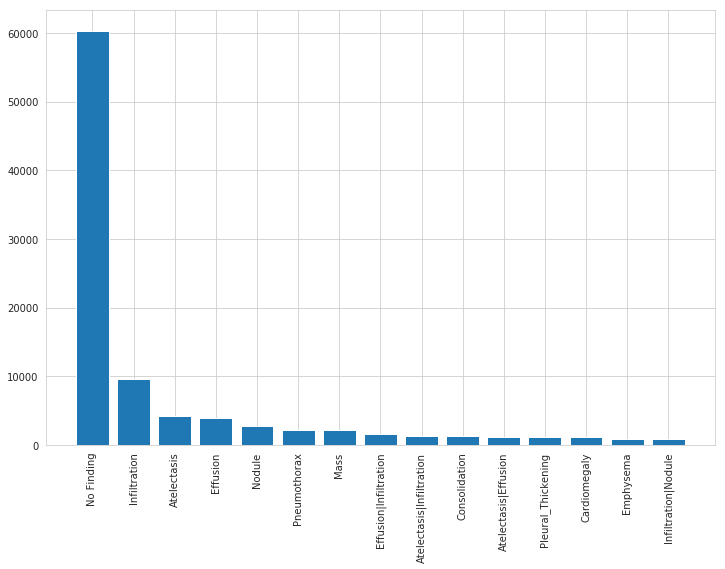

In [8]:
label_counts = data['Finding Labels'].value_counts()[:15]
fig, ax1 = plt.subplots(1,1,figsize = (12, 8))
ax1.bar(np.arange(len(label_counts))+0.5, label_counts)
ax1.set_xticks(np.arange(len(label_counts))+0.5)
_ = ax1.set_xticklabels(label_counts.index, rotation = 90)

<h2> 3.3 Data analysis </h2>

<h3> 3.3.1 Age distribution </h3>

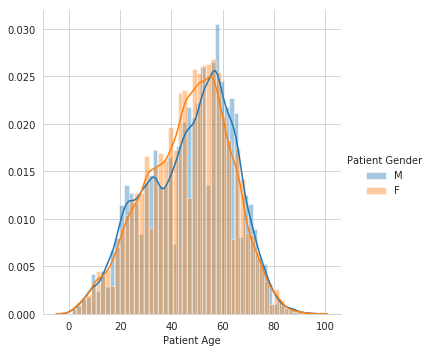

In [9]:
#plt.figure(figsize=(20,15))
sns.FacetGrid(data,hue='Patient Gender',size=5).map(sns.distplot,'Patient Age').add_legend()
plt.show()

#### Observation - Both the gender have almost same distribution

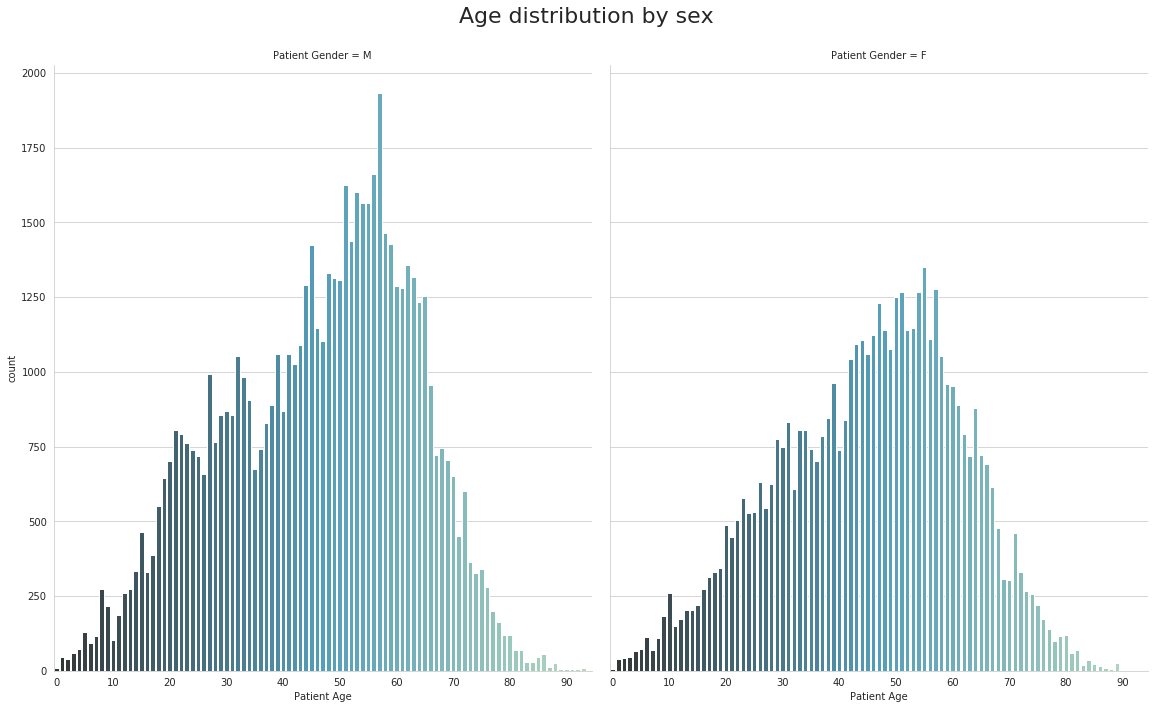

In [10]:
g = sns.factorplot(x="Patient Age", col="Patient Gender",data=data, kind="count",size=10, aspect=0.8,palette="GnBu_d");
g.set_xticklabels(np.arange(0,100));
g.set_xticklabels(step=10);
g.fig.suptitle('Age distribution by sex',fontsize=22);
g.fig.subplots_adjust(top=.9)

<h3> 3.3.2 Disease distribution by age and sex </h3>

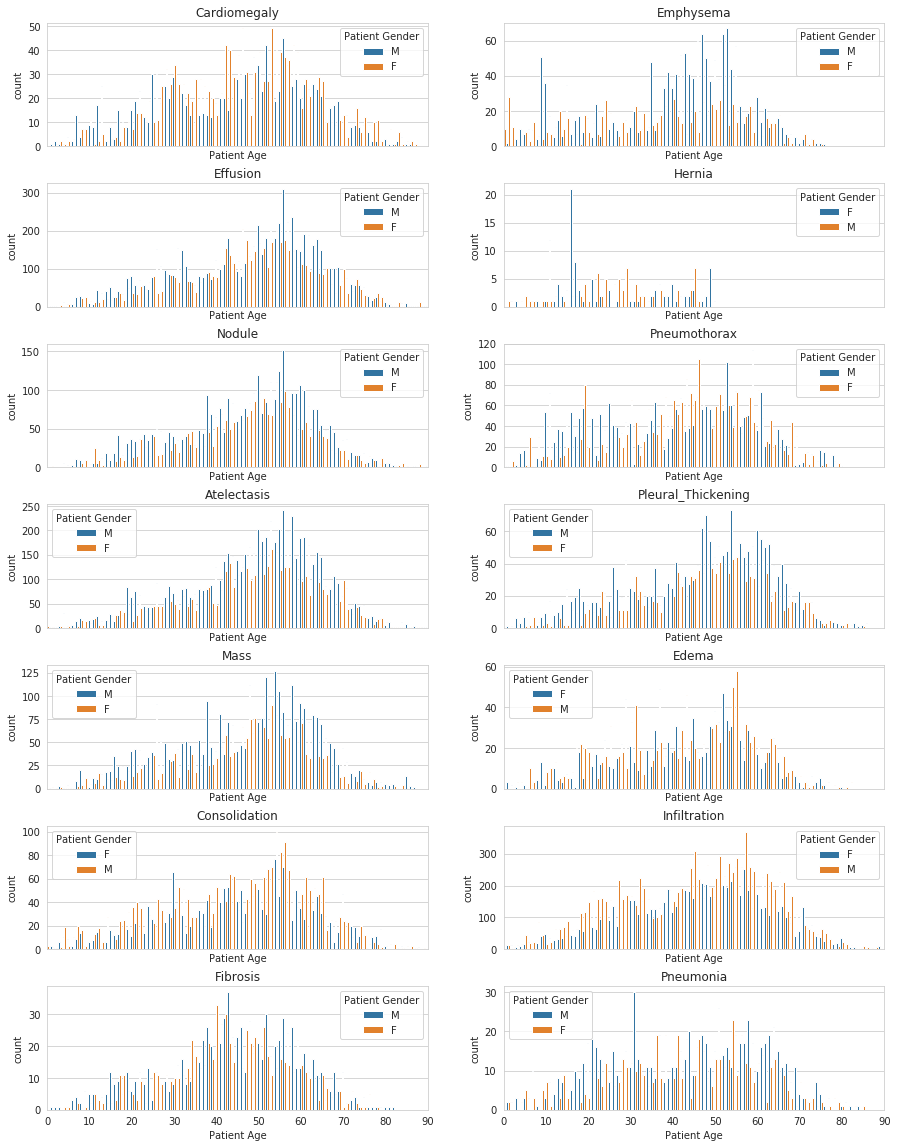

In [12]:
f, axarr = plt.subplots(7, 2, sharex=True,figsize=(15, 20))
pathology_list = ['Cardiomegaly','Emphysema','Effusion','Hernia','Nodule','Pneumothorax','Atelectasis','Pleural_Thickening','Mass','Edema','Consolidation','Infiltration','Fibrosis','Pneumonia']
df = data[data['Finding Labels'] != 'No Finding']
i=0
j=0
x=np.arange(0,100,10)
for pathology in pathology_list :
    index = []
    for k in range(len(df)):
        if pathology in df.iloc[k]['Finding Labels']:
            index.append(k)
    g=sns.countplot(x='Patient Age', hue="Patient Gender",data=df.iloc[index], ax=axarr[i, j])
    axarr[i, j].set_title(pathology)   
    g.set_xlim(0,90)
    g.set_xticks(x)
    g.set_xticklabels(x)
    j=(j+1)%2
    if j==0:
        i=(i+1)%7
f.subplots_adjust(hspace=0.3)

<h3> 3.3.3 No. of each disease by patient gender </h3>

In [13]:
for pathology in pathology_list :
    data[pathology] = data['Finding Labels'].apply(lambda x: 1 if pathology in x else 0)

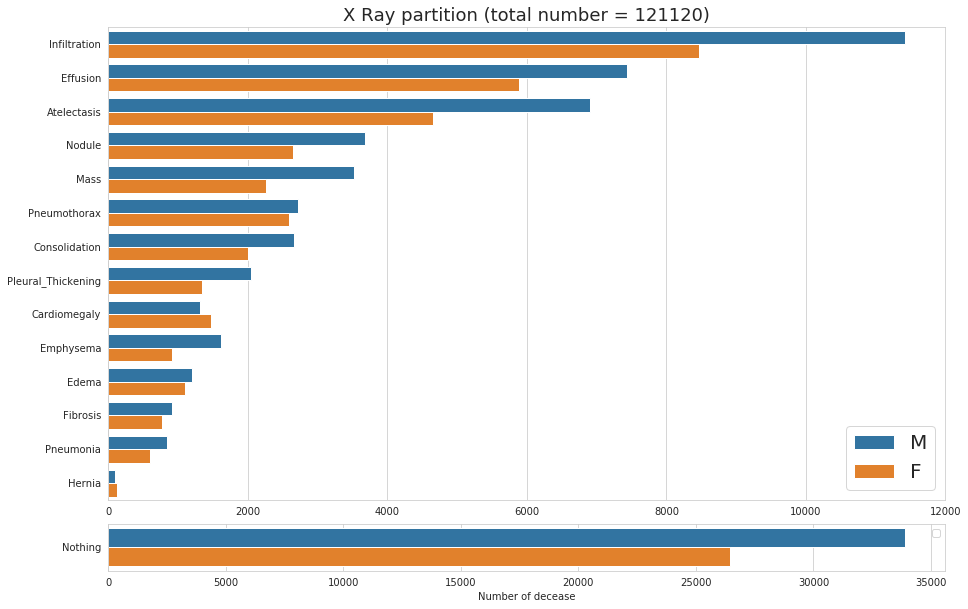

In [14]:
plt.figure(figsize=(15,10))
gs = gridspec.GridSpec(8,1)
ax1 = plt.subplot(gs[:7, :])
ax2 = plt.subplot(gs[7, :])
data1 = pd.melt(data,
             id_vars=['Patient Gender'],
             value_vars = list(pathology_list),
             var_name = 'Category',
             value_name = 'Count')
data1 = data1.loc[data1.Count>0]
g=sns.countplot(y='Category',hue='Patient Gender',data=data1, ax=ax1, order = data1['Category'].value_counts().index)
ax1.set( ylabel="",xlabel="")
ax1.legend(fontsize=20)
ax1.set_title('X Ray partition (total number = 121120)',fontsize=18);

data['Nothing']=data['Finding Labels'].apply(lambda x: 1 if 'No Finding' in x else 0)

data2 = pd.melt(data,
             id_vars=['Patient Gender'],
             value_vars = list(['Nothing']),
             var_name = 'Category',
             value_name = 'Count')
data2 = data2.loc[data2.Count>0]
g=sns.countplot(y='Category',hue='Patient Gender',data=data2,ax=ax2)
ax2.set( ylabel="",xlabel="Number of decease")
ax2.legend('')
plt.subplots_adjust(hspace=.5)

<h3> 3.3.4 Display patient number by Follow-up in details </h3>

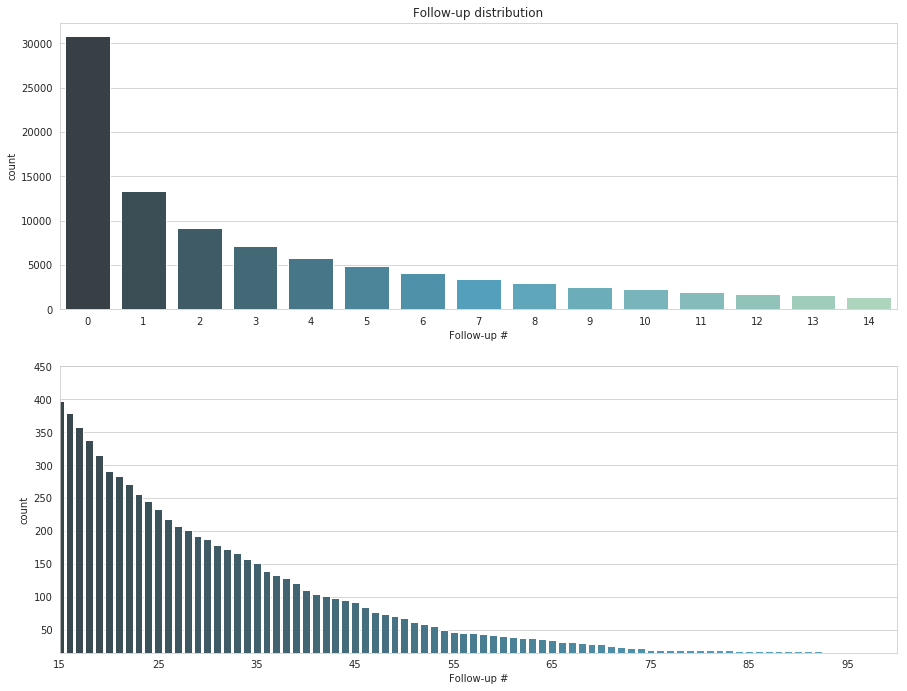

In [15]:
f, (ax1,ax2) = plt.subplots( 2, figsize=(15, 10))

df = data[data['Follow-up #']<15]
g = sns.countplot(x='Follow-up #',data=df,palette="GnBu_d",ax=ax1);

ax1.set_title('Follow-up distribution');
df = data[data['Follow-up #']>14]
g = sns.countplot(x='Follow-up #',data=df,palette="GnBu_d",ax=ax2);
x=np.arange(15,100,10)
g.set_ylim(15,450)
g.set_xlim(15,100)
g.set_xticks(x)
g.set_xticklabels(x)
f.subplots_adjust(top=1)

<h3> 3.3.5 ratio between one and multiple disease </h3>

In [16]:
df=data.groupby('Finding Labels').count().sort_values('Patient ID',ascending=False)
df1=df[['|' in index for index in df.index]].copy()
df2=df[['|' not in index for index in df.index]]
df2=df2[['No Finding' not in index for index in df2.index]]
df2['Finding Labels']=df2.index.values
df1['Finding Labels']=df1.index.values

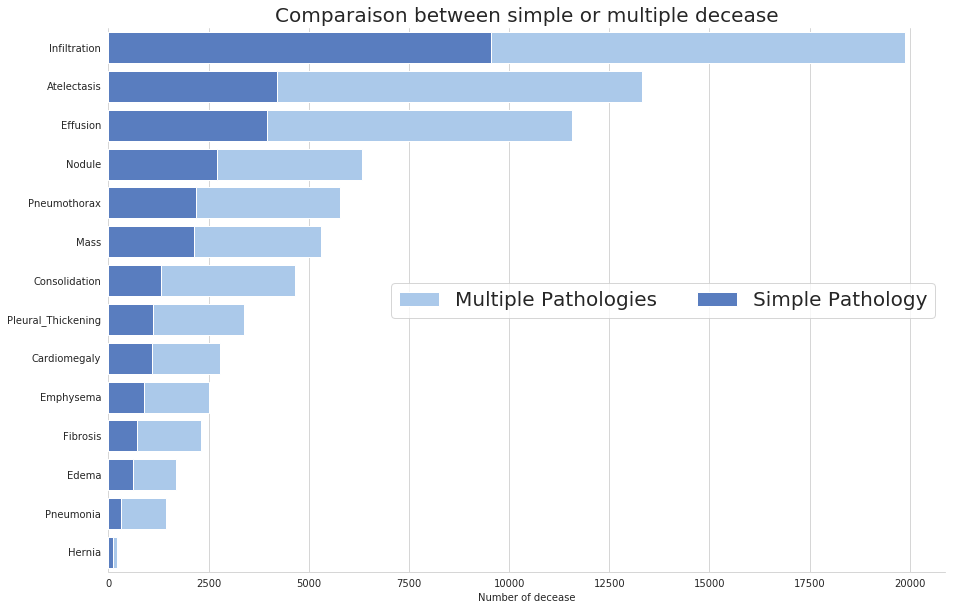

In [17]:
f, ax = plt.subplots(sharex=True,figsize=(15, 10))
sns.set_color_codes("pastel")
g=sns.countplot(y='Category',data=data1, ax=ax, order = data1['Category'].value_counts().index,color='b',label="Multiple Pathologies")
sns.set_color_codes("muted")
g=sns.barplot(x='Patient ID',y='Finding Labels',data=df2, ax=ax, color="b",label="Simple Pathology")
ax.legend(ncol=2, loc="center right", frameon=True,fontsize=20)
ax.set( ylabel="",xlabel="Number of decease")
ax.set_title("Comparaison between simple or multiple decease",fontsize=20)      
sns.despine(left=True)

<h3> 3.3.6 Plot most important pathologies groups for each desease </h3>

In [18]:
#we just keep groups of pathologies which appear more than 30 times
df3=df1.loc[df1['Patient ID']>30,['Patient ID','Finding Labels']]

for pathology in pathology_list:
    df3[pathology]=df3.apply(lambda x: x['Patient ID'] if pathology in x['Finding Labels'] else 0, axis=1)

df3.head(20)

,Patient ID,Finding Labels,Cardiomegaly,Emphysema,Effusion,Hernia,Nodule,Pneumothorax,Atelectasis,Pleural_Thickening,Mass,Edema,Consolidation,Infiltration,Fibrosis,Pneumonia
Finding Labels,,,,,,,,,,,,,,,,
Effusion|Infiltration,1603,Effusion|Infiltration,0,0,1603,0,0,0,0,0,0,0,0,1603,0,0
Atelectasis|Infiltration,1350,Atelectasis|Infiltration,0,0,0,0,0,0,1350,0,0,0,0,1350,0,0
Atelectasis|Effusion,1165,Atelectasis|Effusion,0,0,1165,0,0,0,1165,0,0,0,0,0,0,0
Infiltration|Nodule,829,Infiltration|Nodule,0,0,0,0,829,0,0,0,0,0,0,829,0,0
Atelectasis|Effusion|Infiltration,737,Atelectasis|Effusion|Infiltration,0,0,737,0,0,0,737,0,0,0,0,737,0,0
Cardiomegaly|Effusion,484,Cardiomegaly|Effusion,484,0,484,0,0,0,0,0,0,0,0,0,0,0
Consolidation|Infiltration,441,Consolidation|Infiltration,0,0,0,0,0,0,0,0,0,0,441,441,0,0
Infiltration|Mass,418,Infiltration|Mass,0,0,0,0,0,0,0,0,418,0,0,418,0,0
Effusion|Pneumothorax,403,Effusion|Pneumothorax,0,0,403,0,0,403,0,0,0,0,0,0,0,0


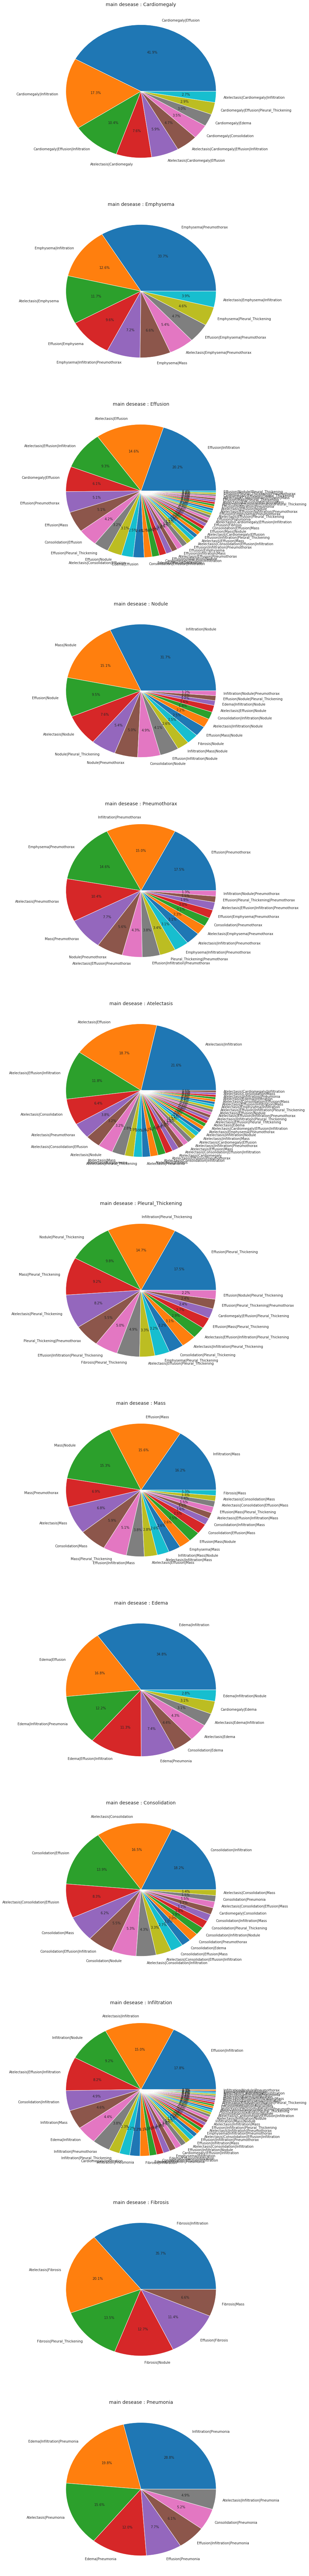

In [19]:
#'Hernia' has not enough values to figure here
df4=df3[df3['Hernia']>0]  # df4.size == 0
#remove 'Hernia' from list
pat_list=[elem for elem in pathology_list if 'Hernia' not in elem]

f, axarr = plt.subplots(13, sharex=True,figsize=(10, 140))
i=0
for pathology in pat_list :
    df4=df3[df3[pathology]>0]
    if df4.size>0:  #'Hernia' has not enough values to figure here
        axarr[i].pie(df4[pathology],labels=df4['Finding Labels'], autopct='%1.1f%%')
        axarr[i].set_title('main desease : '+pathology,fontsize=14)   
        i +=1


<h1> 4. Creating data for model </h1>

In [20]:
data = pd.read_csv('../input/Data_Entry_2017.csv')
data = data[data['Patient Age']<100] #removing datapoints which having age greater than 100
data_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('..', 'input', 'images*', '*', '*.png'))}
print('Scans found:', len(data_image_paths), ', Total Headers', data.shape[0])
data['path'] = data['Image Index'].map(data_image_paths.get)
data['Patient Age'] = data['Patient Age'].map(lambda x: int(x))
data.sample(3)

Scans found: 112120 , Total Headers 112104


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
6768,00001819_007.png,No Finding,7,1819,39,M,AP,2500,2048,0.171,0.171,NaN,../input/images_002/images/00001819_007.png
72151,00017753_027.png,Consolidation|Pneumonia,27,17753,63,M,AP,2500,2048,0.168,0.168,NaN,../input/images_008/images/00017753_027.png
100467,00026641_001.png,Atelectasis,1,26641,55,F,AP,3056,2544,0.139,0.139,NaN,../input/images_011/images/00026641_001.png


In [21]:
data['Finding Labels'] = data['Finding Labels'].map(lambda x: x.replace('No Finding', ''))
from itertools import chain
all_labels = np.unique(list(chain(*data['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        data[c_label] = data['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
data.sample(3)

All Labels (14): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
64844,00016009_044.png,Effusion,44,16009,55,F,AP,2500,2048,0.168,0.168,NaN,../input/images_007/images/00016009_044.png,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10109,00002628_001.png,Fibrosis|Pleural_Thickening,1,2628,61,M,PA,2500,2048,0.171,0.171,NaN,../input/images_002/images/00002628_001.png,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
96447,00025389_000.png,,0,25389,2,F,PA,1550,1167,0.143,0.143,NaN,../input/images_011/images/00025389_000.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
# keep at least 1000 cases
MIN_CASES = 1000
all_labels = [c_label for c_label in all_labels if data[c_label].sum()>MIN_CASES]
print('Clean Labels ({})'.format(len(all_labels)), 
      [(c_label,int(data[c_label].sum())) for c_label in all_labels])


Clean Labels (13) [('Atelectasis', 11558), ('Cardiomegaly', 2776), ('Consolidation', 4667), ('Edema', 2302), ('Effusion', 13316), ('Emphysema', 2516), ('Fibrosis', 1686), ('Infiltration', 19891), ('Mass', 5779), ('Nodule', 6331), ('Pleural_Thickening', 3384), ('Pneumonia', 1430), ('Pneumothorax', 5301)]


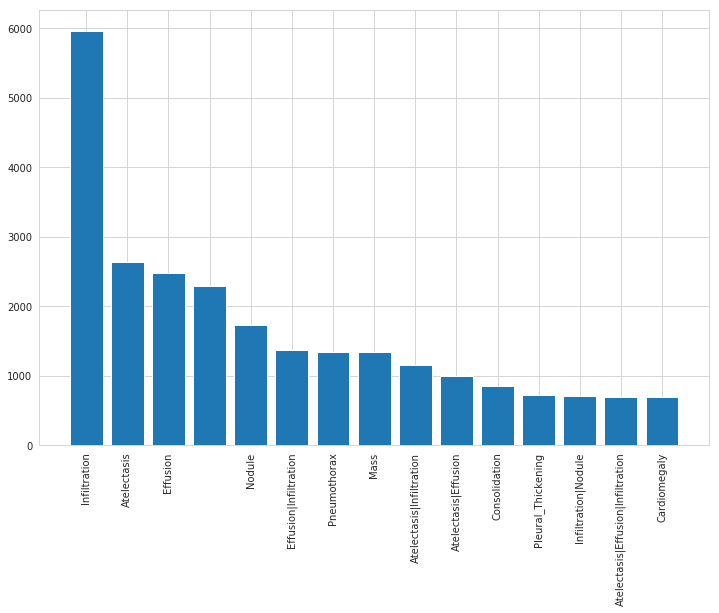

In [23]:
# since the dataset is very unbiased, we can resample it to be a more reasonable collection
# weight is 0.04 + number of findings
sample_weights = data['Finding Labels'].map(lambda x: len(x.split('|')) if len(x)>0 else 0).values + 4e-2
sample_weights /= sample_weights.sum()
data = data.sample(40000, weights=sample_weights)

label_counts = data['Finding Labels'].value_counts()[:15]
fig, ax1 = plt.subplots(1,1,figsize = (12, 8))
ax1.bar(np.arange(len(label_counts))+0.5, label_counts)
ax1.set_xticks(np.arange(len(label_counts))+0.5)
_ = ax1.set_xticklabels(label_counts.index, rotation = 90)


In [24]:
# creating vector of diseases
data['disease_vec'] = data.apply(lambda x: [x[all_labels].values], 1).map(lambda x: x[0])


In [25]:
data.iloc[0]['disease_vec']

array([0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0],
      dtype=object)

In [26]:
from sklearn.model_selection import train_test_split
train_df, valid_df = train_test_split(data, 
                                   test_size = 0.25, 
                                   random_state = 2018,
                                   stratify = data['Finding Labels'].map(lambda x: x[:4]))
print('train', train_df.shape[0], 'validation', valid_df.shape[0])

train 30000 validation 10000


In [27]:
from keras.preprocessing.image import ImageDataGenerator
IMG_SIZE = (128, 128)
core_idg = ImageDataGenerator(samplewise_center=True, 
                              samplewise_std_normalization=True, 
                              horizontal_flip = True, 
                              vertical_flip = False, 
                              height_shift_range= 0.05, 
                              width_shift_range=0.1, 
                              rotation_range=5, 
                              shear_range = 0.1,
                              fill_mode = 'reflect',
                              zoom_range=0.15)

Using TensorFlow backend.


In [28]:
def flow_from_dataframe(img_data_gen, in_df, path_col, y_col, **dflow_args):
    base_dir = os.path.dirname(in_df[path_col].values[0])
    print('## Ignore next message from keras, values are replaced anyways')
    df_gen = img_data_gen.flow_from_directory(base_dir, 
                                     class_mode = 'sparse',
                                    **dflow_args)
    df_gen.filenames = in_df[path_col].values
    df_gen.classes = np.stack(in_df[y_col].values)
    df_gen.samples = in_df.shape[0]
    df_gen.n = in_df.shape[0]
    df_gen._set_index_array()
    df_gen.directory = '' # since we have the full path
    print('Reinserting dataframe: {} images'.format(in_df.shape[0]))
    return df_gen


In [29]:
train_gen = flow_from_dataframe(core_idg, train_df, 
                             path_col = 'path',
                            y_col = 'disease_vec', 
                            target_size = IMG_SIZE,
                             color_mode = 'grayscale',
                            batch_size = 32)

valid_gen = flow_from_dataframe(core_idg, valid_df, 
                             path_col = 'path',
                            y_col = 'disease_vec', 
                            target_size = IMG_SIZE,
                             color_mode = 'grayscale',
                            batch_size = 256) # we can use much larger batches for evaluation
# used a fixed dataset for evaluating the algorithm
test_X, test_Y = next(flow_from_dataframe(core_idg, 
                               valid_df, 
                             path_col = 'path',
                            y_col = 'disease_vec', 
                            target_size = IMG_SIZE,
                             color_mode = 'grayscale',
                            batch_size = 1024)) # one big batch

## Ignore next message from keras, values are replaced anyways
Found 0 images belonging to 0 classes.
Reinserting dataframe: 30000 images
## Ignore next message from keras, values are replaced anyways
Found 0 images belonging to 0 classes.
Reinserting dataframe: 10000 images
## Ignore next message from keras, values are replaced anyways
Found 0 images belonging to 0 classes.
Reinserting dataframe: 10000 images


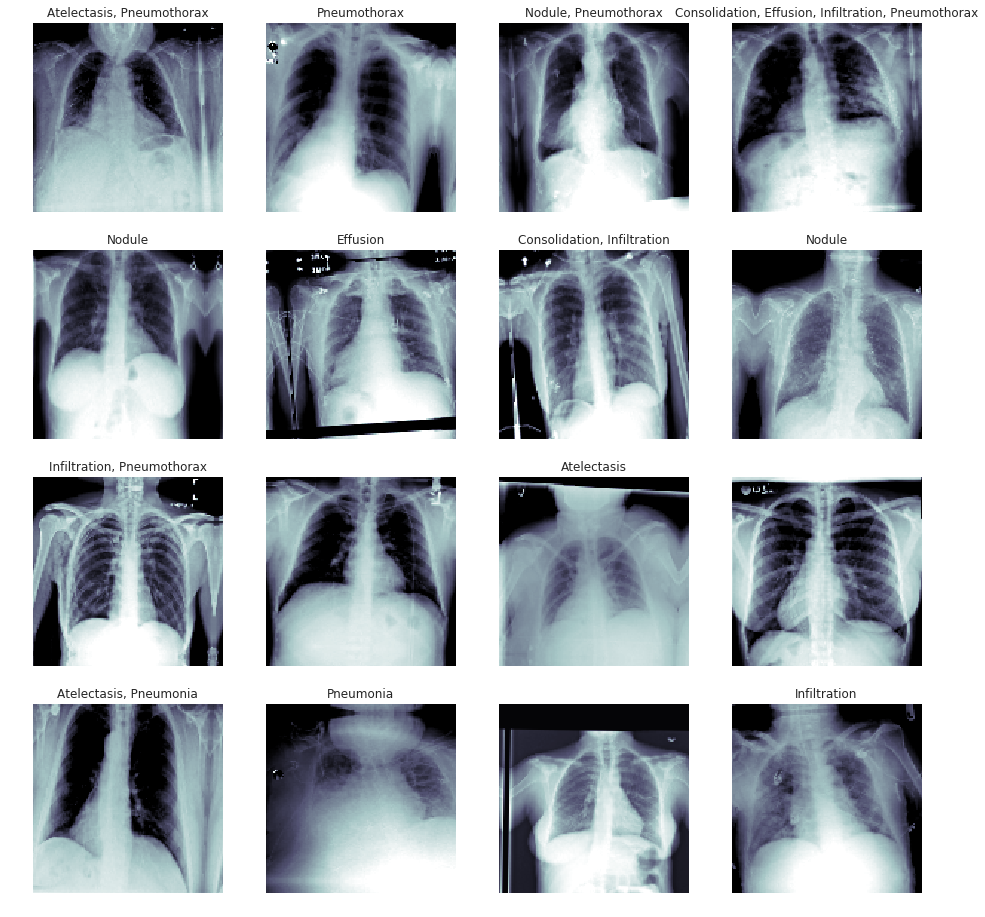

In [30]:
t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone', vmin = -1.5, vmax = 1.5)
    c_ax.set_title(', '.join([n_class for n_class, n_score in zip(all_labels, c_y) 
                             if n_score>0.5]))
    c_ax.axis('off')

### Create a simple model

Here we make a simple model to train using MobileNet as a base and then adding a GAP layer (Flatten could also be added), dropout, and a fully-connected layer to calculate specific features


In [31]:
from keras.applications.mobilenet import MobileNet
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from keras.models import Sequential
mobilenet_model = MobileNet(input_shape =  t_x.shape[1:], 
                                 include_top = False, weights = None)
multi_disease_model = Sequential()
multi_disease_model.add(mobilenet_model)
multi_disease_model.add(GlobalAveragePooling2D())
multi_disease_model.add(Dropout(0.5))
multi_disease_model.add(Dense(512))
multi_disease_model.add(Dropout(0.5))
multi_disease_model.add(Dense(len(all_labels), activation = 'sigmoid'))
multi_disease_model.compile(optimizer = 'adam', loss = 'binary_crossentropy',
                           metrics = ['binary_accuracy', 'mae'])
multi_disease_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_128 (Model)   (None, 4, 4, 1024)        3228288   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1024)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 13)                6669      
Total params: 3,759,757
Trainable params: 3,737,869
Non-trainable params: 21,888
_____________________________________________________________

In [32]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}_weights.best.hdf5".format('xray_class')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=3)
callbacks_list = [checkpoint, early]

### First Round

Here we do a first round of training to get a few initial low hanging fruit results


In [35]:
multi_disease_model.fit_generator(train_gen, 
                                  steps_per_epoch=50,
                                  validation_data = (test_X, test_Y), 
                                  epochs = 10, 
                                  callbacks = callbacks_list)

Epoch 1/10
50/50 [==============================] - 241s 5s/step - loss: 0.3396 - binary_accuracy: 0.8756 - mean_absolute_error: 0.1970 - val_loss: 0.4291 - val_binary_accuracy: 0.8389 - val_mean_absolute_error: 0.1812

Epoch 00001: val_loss did not improve from 0.34786
Epoch 2/10
50/50 [==============================] - 257s 5s/step - loss: 0.3391 - binary_accuracy: 0.8750 - mean_absolute_error: 0.1956 - val_loss: 0.3568 - val_binary_accuracy: 0.8632 - val_mean_absolute_error: 0.1918

Epoch 00002: val_loss did not improve from 0.34786
Epoch 3/10
50/50 [==============================] - 236s 5s/step - loss: 0.3368 - binary_accuracy: 0.8744 - mean_absolute_error: 0.1947 - val_loss: 0.3489 - val_binary_accuracy: 0.8648 - val_mean_absolute_error: 0.1839

Epoch 00003: val_loss did not improve from 0.34786
Epoch 4/10
50/50 [==============================] - 258s 5s/step - loss: 0.3376 - binary_accuracy: 0.8744 - mean_absolute_error: 0.1956 - val_loss: 0.3330 - val_binary_accuracy: 0.8642 - 

### Check Output

Here we see how many positive examples we have of each category


In [36]:
for c_label, s_count in zip(all_labels, 100*np.mean(test_Y,0)):
    print('%s: %2.2f%%' % (c_label, s_count))

Atelectasis: 24.12%
Cardiomegaly: 5.47%
Consolidation: 10.84%
Edema: 4.98%
Effusion: 29.00%
Emphysema: 4.79%
Fibrosis: 2.93%
Infiltration: 40.23%
Mass: 11.91%
Nodule: 10.84%
Pleural_Thickening: 6.25%
Pneumonia: 3.03%
Pneumothorax: 10.25%


In [37]:
pred_Y = multi_disease_model.predict(test_X, batch_size = 32, verbose = True)

1024/1024 [==============================] - 28s 27ms/step


### ROC Curves

While a very oversimplified metric, we can show the ROC curve for each metric


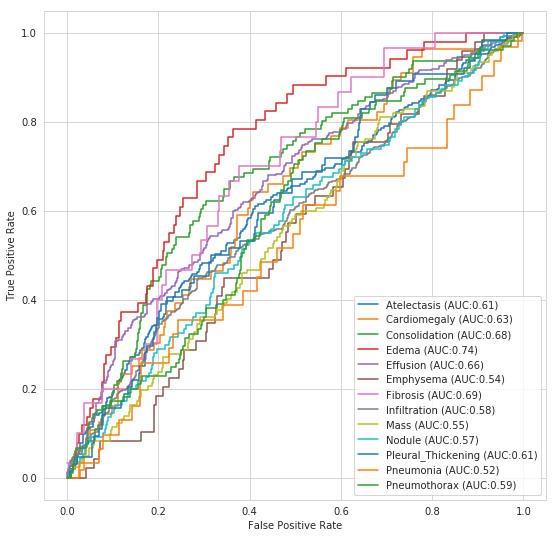

In [38]:
from sklearn.metrics import roc_curve, auc
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
for (idx, c_label) in enumerate(all_labels):
    fpr, tpr, thresholds = roc_curve(test_Y[:,idx].astype(int), pred_Y[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
fig.savefig('barely_trained_net.png')

### Continued Training

Now we do a much longer training process to see how the results improve


In [ ]:
multi_disease_model.fit_generator(train_gen, 
                                  steps_per_epoch = 50,
                                  validation_data =  (test_X, test_Y), 
                                  epochs = 5, 
                                  callbacks = callbacks_list)

In [39]:
# load the best weights
multi_disease_model.load_weights(weight_path)

In [40]:
pred_Y = multi_disease_model.predict(test_X, batch_size = 32, verbose = True)

1024/1024 [==============================] - 28s 27ms/step


In [41]:
# look at how often the algorithm predicts certain diagnoses 
for c_label, p_count, t_count in zip(all_labels, 
                                     100*np.mean(pred_Y,0), 
                                     100*np.mean(test_Y,0)):
    print('%s: Dx: %2.2f%%, PDx: %2.2f%%' % (c_label, t_count, p_count))

Atelectasis: Dx: 24.12%, PDx: 17.98%
Cardiomegaly: Dx: 5.47%, PDx: 5.39%
Consolidation: Dx: 10.84%, PDx: 8.32%
Edema: Dx: 4.98%, PDx: 9.06%
Effusion: Dx: 29.00%, PDx: 31.50%
Emphysema: Dx: 4.79%, PDx: 4.46%
Fibrosis: Dx: 2.93%, PDx: 2.99%
Infiltration: Dx: 40.23%, PDx: 45.41%
Mass: Dx: 11.91%, PDx: 12.45%
Nodule: Dx: 10.84%, PDx: 8.27%
Pleural_Thickening: Dx: 6.25%, PDx: 4.61%
Pneumonia: Dx: 3.03%, PDx: 4.44%
Pneumothorax: Dx: 10.25%, PDx: 7.43%


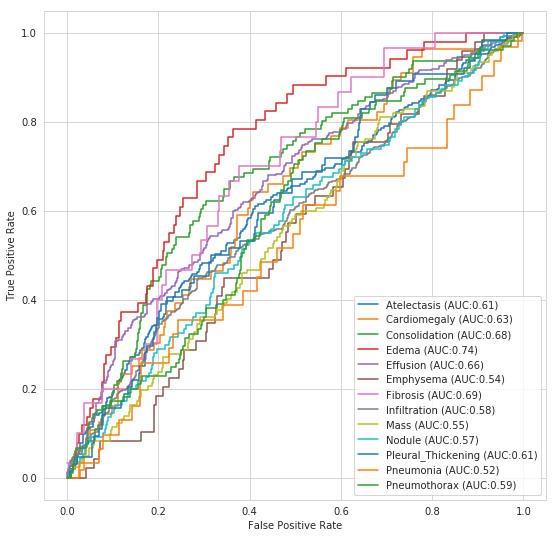

In [42]:
from sklearn.metrics import roc_curve, auc
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
for (idx, c_label) in enumerate(all_labels):
    fpr, tpr, thresholds = roc_curve(test_Y[:,idx].astype(int), pred_Y[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
fig.savefig('trained_net.png')

### Show a few images and associated predictions

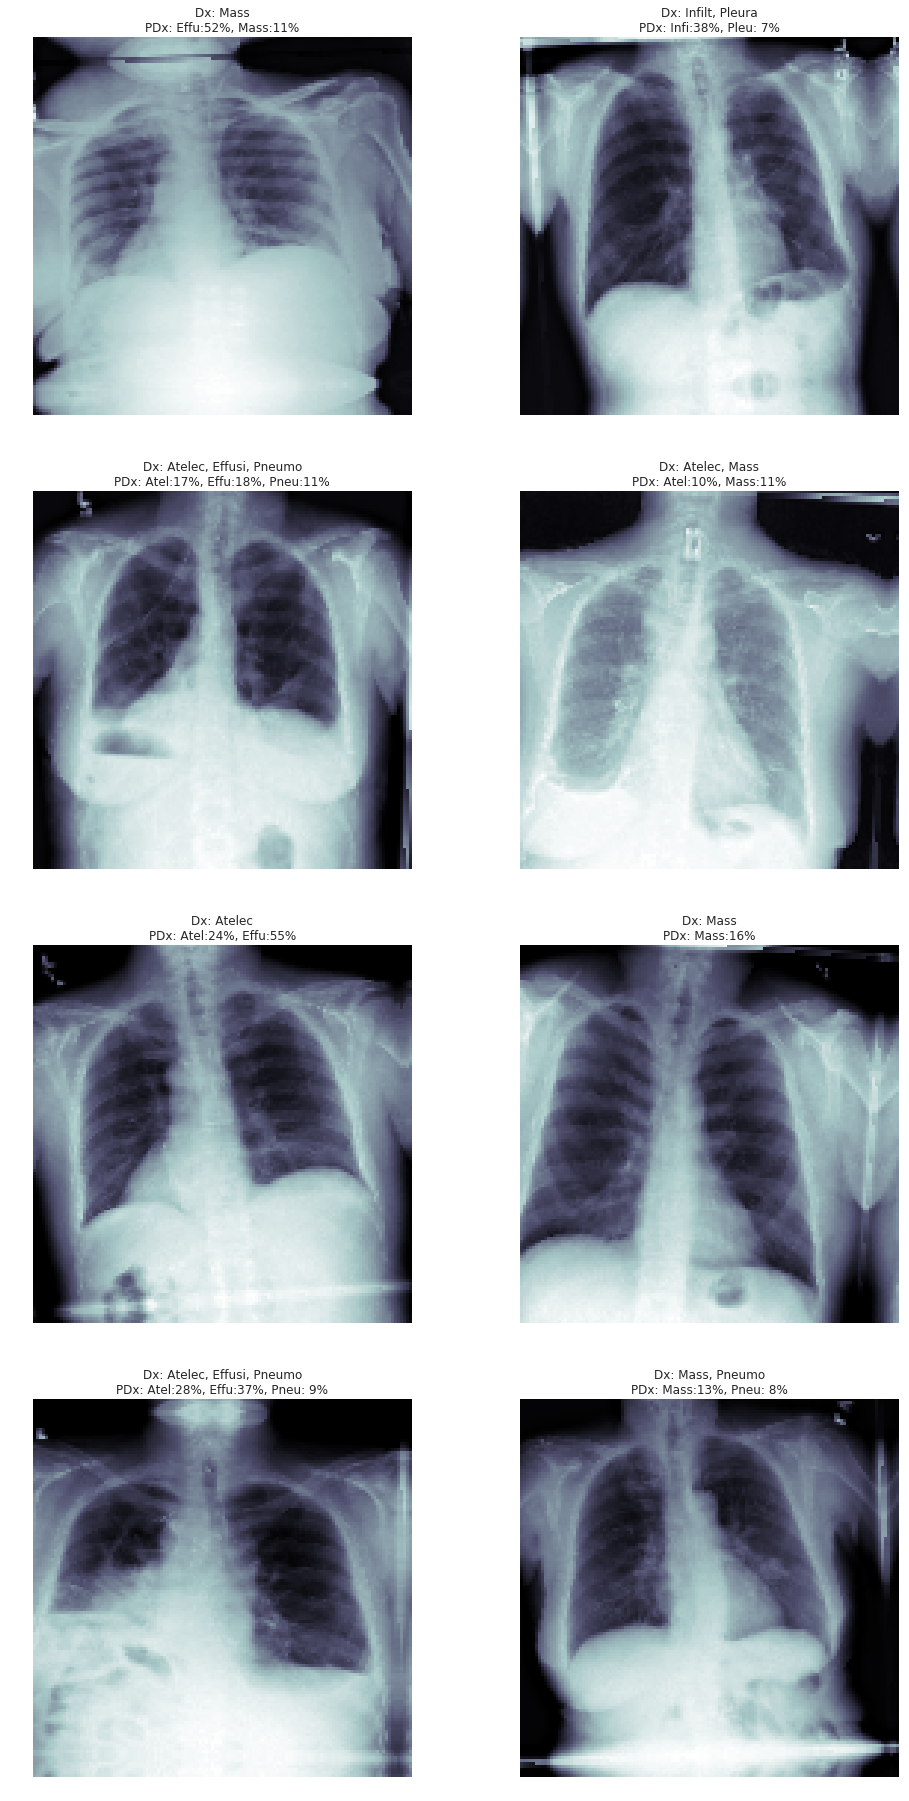

In [43]:
sickest_idx = np.argsort(np.sum(test_Y, 1)<1)
fig, m_axs = plt.subplots(4, 2, figsize = (16, 32))
for (idx, c_ax) in zip(sickest_idx, m_axs.flatten()):
    c_ax.imshow(test_X[idx, :,:,0], cmap = 'bone')
    stat_str = [n_class[:6] for n_class, n_score in zip(all_labels, 
                                                                  test_Y[idx]) 
                             if n_score>0.5]
    pred_str = ['%s:%2.0f%%' % (n_class[:4], p_score*100)  for n_class, n_score, p_score in zip(all_labels, 
                                                                  test_Y[idx], pred_Y[idx]) 
                             if (n_score>0.5) or (p_score>0.5)]
    c_ax.set_title('Dx: '+', '.join(stat_str)+'\nPDx: '+', '.join(pred_str))
    c_ax.axis('off')
fig.savefig('trained_img_predictions.png')